# MCS 275 Spring 2022 Lecture 40

## Imports

In [19]:
from urllib.request import urlopen
import bs4

## Utility functions

A function to get the content of a web page as a string (basically, what we did manually in Lecture 39).

In [20]:
def urlreadtext(url,*args,**kwargs):
    """
    Retrieve URL `url` and return the response body decoded as a string. If
    content-type specifies a charset, use that. Otherwise, attempt UTF-8
    decoding.  Returns the resulting string.

    Additional arguments are passed to `urllib.request.urlopen`.
    """
    print("Opening URL '{}'".format(url))
    with urlopen(url,*args,**kwargs) as res:
        # Get raw data (bytes)
        data = res.read()
        # Determine the encoding
        encoding = res.headers.get_content_charset()
        if encoding is None:
            # Danger: no encoding was specified in the headers
            # Try using UTF-8
            encoding = "UTF-8"

        # TODO: Detect if the response indicates a non-text content type, and if
        # so, raise an informative exception rather than just letting the
        # attempt to decode as a string fail.

        # Convert to string and return
        return data.decode(encoding)

# Let's apply caching so that we only make one request to any given
# URL, even if `urlreadtext` is called many times
import functools
urlreadtext = functools.lru_cache(maxsize=None)(urlreadtext)

In [21]:
urlreadtext("http://example.com")

Opening URL 'http://example.com'


'<!doctype html>\n<html>\n<head>\n    <title>Example Domain</title>\n\n    <meta charset="utf-8" />\n    <meta http-equiv="Content-type" content="text/html; charset=utf-8" />\n    <meta name="viewport" content="width=device-width, initial-scale=1" />\n    <style type="text/css">\n    body {\n        background-color: #f0f0f2;\n        margin: 0;\n        padding: 0;\n        font-family: -apple-system, system-ui, BlinkMacSystemFont, "Segoe UI", "Open Sans", "Helvetica Neue", Helvetica, Arial, sans-serif;\n        \n    }\n    div {\n        width: 600px;\n        margin: 5em auto;\n        padding: 2em;\n        background-color: #fdfdff;\n        border-radius: 0.5em;\n        box-shadow: 2px 3px 7px 2px rgba(0,0,0,0.02);\n    }\n    a:link, a:visited {\n        color: #38488f;\n        text-decoration: none;\n    }\n    @media (max-width: 700px) {\n        div {\n            margin: 0 auto;\n            width: auto;\n        }\n    }\n    </style>    \n</head>\n\n<body>\n<div>\n    <

In [22]:
urlreadtext("http://example.com")

'<!doctype html>\n<html>\n<head>\n    <title>Example Domain</title>\n\n    <meta charset="utf-8" />\n    <meta http-equiv="Content-type" content="text/html; charset=utf-8" />\n    <meta name="viewport" content="width=device-width, initial-scale=1" />\n    <style type="text/css">\n    body {\n        background-color: #f0f0f2;\n        margin: 0;\n        padding: 0;\n        font-family: -apple-system, system-ui, BlinkMacSystemFont, "Segoe UI", "Open Sans", "Helvetica Neue", Helvetica, Arial, sans-serif;\n        \n    }\n    div {\n        width: 600px;\n        margin: 5em auto;\n        padding: 2em;\n        background-color: #fdfdff;\n        border-radius: 0.5em;\n        box-shadow: 2px 3px 7px 2px rgba(0,0,0,0.02);\n    }\n    a:link, a:visited {\n        color: #38488f;\n        text-decoration: none;\n    }\n    @media (max-width: 700px) {\n        div {\n            margin: 0 auto;\n            width: auto;\n        }\n    }\n    </style>    \n</head>\n\n<body>\n<div>\n    <

A function to generate URLs for MCS 275 related things.

In [23]:
def mcs275url(itemtype,number):
    urlbase = "http://www.dumas.io/teaching/2022/spring/mcs275/"
    sub_fmts = {
        "homework":"nbview/homework/homework{}.html",
        "homework solution":"nbview/homework/homework{}soln.html",
        "worksheet":"nbview/worksheets/worksheet{}.html",
        "worksheet solution":"nbview/worksheets/worksheet{}soln.html",
        "project":"nbview/projects/project{}.html",
        "lecture":"slides/lecture{}.html"
    }
    if itemtype not in sub_fmts:
        raise ValueError("itemtype '{}' unknown; must be one of {}".format(itemtype,sub_fmts.keys()))
    return urlbase + sub_fmts[itemtype].format(number)

In [24]:
mcs275url("lecture",40)

'http://www.dumas.io/teaching/2022/spring/mcs275/slides/lecture40.html'

In [25]:
mcs275url("homework solution",12)

'http://www.dumas.io/teaching/2022/spring/mcs275/nbview/homework/homework12soln.html'

In [26]:
mcs275url("project",4) # reminder: Due Fri 29 April!

'http://www.dumas.io/teaching/2022/spring/mcs275/nbview/projects/project4.html'

In [27]:
s = urlreadtext(mcs275url("lecture",40))

Opening URL 'http://www.dumas.io/teaching/2022/spring/mcs275/slides/lecture40.html'


In [29]:
s[:100]

'<!doctype html>\n<html>\n<head>\n    <meta charset="utf-8">\n    <meta name="viewport" content="width=de'

Let's get the title of lecture 40.

## Level 0 HTML parsing

In [35]:
s = urlreadtext(mcs275url("lecture",40))
start = s.find("<title>")
stop = s.find("</title>")
print("The title of lecture 40 is:",s[start+7:stop])

The title of lecture 40 is: Lec 40: Parsing and scraping HTML


## Level 1 HTML parsing

In [41]:
import html.parser

class TitleExtractor(html.parser.HTMLParser):
    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.listening = False
        self.captured = ""
    def handle_starttag(self, tag, attrs):
        #print("Start tag",tag)
        if tag == "title":
            self.listening = True
    def handle_endtag(self, tag):
        #print("End tag",tag)
        if tag == "title":
            self.listening = False
    def handle_data(self, data):
        if self.listening:
            self.captured += data

In [44]:
X = TitleExtractor()
X.feed(urlreadtext(mcs275url("lecture",40)))
print("The title of lecture 40 is:",X.captured)

The title of lecture 40 is: Lec 40: Parsing and scraping HTML


## Level 2 HTML parsing

In [53]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(
    urlreadtext(mcs275url("lecture",40)),
    "html.parser"  # Use Python's built-in parser
)
print("The title of lecture 40 is:",soup.title.text)

The title of lecture 40 is: Lec 40: Parsing and scraping HTML


## MCS 275 slides analysis

In [54]:
from bs4 import BeautifulSoup
import time

lecture_titles = {}
for n in range(1,41):
    time.sleep(0.1)
    soup = BeautifulSoup(
        urlreadtext(mcs275url("lecture",n)),
        "html.parser"  # Use Python's built-in parser
    )
    lecture_titles[n] = soup.title.text

Opening URL 'http://www.dumas.io/teaching/2022/spring/mcs275/slides/lecture1.html'
Opening URL 'http://www.dumas.io/teaching/2022/spring/mcs275/slides/lecture2.html'
Opening URL 'http://www.dumas.io/teaching/2022/spring/mcs275/slides/lecture3.html'
Opening URL 'http://www.dumas.io/teaching/2022/spring/mcs275/slides/lecture4.html'
Opening URL 'http://www.dumas.io/teaching/2022/spring/mcs275/slides/lecture5.html'
Opening URL 'http://www.dumas.io/teaching/2022/spring/mcs275/slides/lecture6.html'
Opening URL 'http://www.dumas.io/teaching/2022/spring/mcs275/slides/lecture7.html'
Opening URL 'http://www.dumas.io/teaching/2022/spring/mcs275/slides/lecture8.html'
Opening URL 'http://www.dumas.io/teaching/2022/spring/mcs275/slides/lecture9.html'
Opening URL 'http://www.dumas.io/teaching/2022/spring/mcs275/slides/lecture10.html'
Opening URL 'http://www.dumas.io/teaching/2022/spring/mcs275/slides/lecture11.html'
Opening URL 'http://www.dumas.io/teaching/2022/spring/mcs275/slides/lecture12.html'
O

In [55]:
lecture_titles

{1: 'Lec 1: Introduction',
 2: 'Lec 2: Python tour part I',
 3: 'Lec 3: Python tour part II',
 4: 'Lec 4: Operator overloading',
 5: 'Lec 5: Inheritance',
 6: 'Lec 6: Inheritance II',
 7: 'Lec 7: Notebooks',
 8: 'Lec 8: Variadic functions and decorators',
 9: 'Lec 9: Context Managers',
 10: 'Lec 10: Errors and debugging',
 11: 'Lec 11: pdb',
 12: 'Lec 12: Recursion',
 13: 'Lec 13: Recursion vs iteration',
 14: 'Lec 14: Recursion vs iteration II',
 15: 'Lec 15: Recursion with backtracking',
 16: 'Lec 16: Mergesort',
 17: 'Lec 17: Quicksort',
 18: 'Lec 18: Comparison sorts',
 19: 'Lec 19: Trees',
 20: 'Lec 20: Binary Search Trees (BST)',
 21: 'Lec 21: BST and tree traversals',
 22: 'Lec 22: set and defaultdict',
 23: 'Lec 23: CSV and JSON',
 24: 'Lec 24: Pillow',
 25: 'Lec 25: Numpy',
 26: 'Lec 26: Numpy II',
 27: 'Lec 27: Julia sets',
 28: 'Lec 28: Matplotlib',
 29: 'Lec 29: Matplotlib II',
 30: 'Lec 30: Databases',
 31: 'Lec 31: Machine learning',
 32: 'Lec 32: SQL and SQLite II',
 33:

In [56]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(
    urlreadtext(mcs275url("lecture",40)),
    "html.parser"  # Use Python's built-in parser
)

In [62]:
soup.find("section").h1  # Does the first slide have an h1?

<h1>Lecture 40</h1>

In [67]:
len(soup.find_all("section")) # number of slides in lecture 40

21

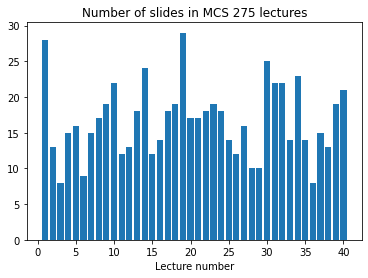

In [73]:
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

lecture_numbers = list(range(1,41))
lecture_slide_counts = []
for n in range(1,41):
    soup = BeautifulSoup(
        urlreadtext(mcs275url("lecture",n)),
        "html.parser"  # Use Python's built-in parser
    )
    lecture_slide_counts.append(len(soup.find_all("section")))
    

plt.bar(lecture_numbers,lecture_slide_counts)
plt.title("Number of slides in MCS 275 lectures")
plt.xlabel("Lecture number")
plt.show()